## Introduction

In data modelling section, various linear and tree based method has been studied. Given dataset contains numerical as well as categorical features. For modelling purpose categorical data need to be convert to numeric one and it is termed as encoding. Label encoder, ordinal encoder, one hot encoder, binary encoder are various types of encoding. In this context, one hot encoding is used in case of linear modelling and label encoder is used in case of tree based modelling.

### **Why One Hot Encoding(OHE) in linear model?**
Simple label encoder encodes categorical level with random number. If linear model is chosen, then during training phase these number could be misinterpreted and model wrongly assumes that there is certain order.OHE is used to avoid such wrong interpretation. In OHE,seperate feature has been created for each categorical level and it is coded as 0 or 1 based on the presence of that level for given sample.

Therefore, seperate dataset has been prepared for linear model and tree based model.


## Dataflow


This notebook focused on linear modelling only. Engineered and filtered dataset(train and test) from previous section has been used for modelling purpose.Training set contains total 84 columns including target along with its logform and Testing set contains 82 columns. Feature set includes both categorical and numerical type data. Data follows following path to predict final SalePrice on test data

1. Prepare a data: Numerical features kept as it is and categorical features are encoded using OHE
2. Pick model: one model picked from linear regresssion, ridge, lasso, elastic net at a time
3. Grid search for appropriate hyperparameter setting
4. Error evaluation: MAE(mean absolute error), RMSE(root mean squared error), r2score(coefficient of determination), explained variance for validation data
5. Best model is chosen based on lowest RMSE as well as other metrics are monitored for its validity,
6. Feature selection for best model
7. Hyperparameter tuning and retraining with best parameter for model
8. Testing out final model on test set.

### Something about Error Evaluation:

**MAE and RMSE:**

MAE is termed as mean absolute error and represents average error amount while RMSE is termed as root mean square error its square root of average of squared error.It has ability to panalize larger error more. Both are ranges from 0 to infinity and negatively oriented score . It means lower values are better. In regular case, RMSE >= MAE. If there are some error ouliers means some very less frquent high error terms are present then RMSE <= MAE\*sqrt(n). Here, n represnts number of samples under consideration. Therefore, we can set bounding for RMSE; upper bound is MAE\*sqrt(n) and lower bound is MAE. (Refer this nice article for more details: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)

In model evaluation step, we are calculating RMSE and MAE for different version of each model type  (version refer as various values of model parameter( alpha in this case )). and try to observe the plot of RMSE. Desirable behaviour of RMSE plot is it must be much closer or equal to lower bound. If such behavior is not observed then it implies that our model is performing worst.

**R2-score and explained variance:**

Explained variance (also called explained variation) is used to measure the discrepancy between a model and actual data. Higher percentages of explained variance indicates a stronger strength of association. It also means that you make better predictions. R2-score is coefficient of determination which measures the amount of variation explained by the (least-squares) Linear Regression. Both are positively oriented score and range is 0 to 1.

R2 = 1 - [(Sum of Squared Residuals / n) / Variancey_actual]

Explained Variance Score = 1 - [Variance(Ypredicted - Yactual) / Variancey_actual]

Variance(Ypredicted - Yactual) = (Sum of Squared Residuals - Mean Error) / n 

When we compare the R2 Score with the Explained Variance Score, we are basically checking the Mean Error; so if R2 = Explained Variance Score, that means The Mean Error = 0

The Mean Error reflects the tendency of our estimator, that is: the Biased v.s Unbiased Estimation.

So in model evaluation step, if we find R2 score = Explained Variance score that means our model is unbiased and if they are not equal then Mean Error != 0 and our model is biased. Bias can be interpreted from sign of mean error, positive means overestimating and negative means underestimating.

## Load Data

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer,mean_squared_error,mean_absolute_error,r2_score,explained_variance_score


In [2]:
train = pd.read_csv('/kaggle/input/sec3-eda-fe-categorical/eng_filt_train.csv')
test = pd.read_csv('/kaggle/input/sec3-eda-fe-categorical/eng_filt_test.csv')
train['MSSubClass'] = train['MSSubClass'].astype('category')
test['MSSubClass'] = test['MSSubClass'].astype('category')
traintest = pd.concat([train,test],axis=0,ignore_index = True)

In [3]:
train.shape,test.shape,traintest.shape

((1425, 84), (1459, 82), (2884, 84))

In [4]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorc

## Prepare Data

In [5]:
def prepare_data_for_linear_model(whole,tr,te):
    """ 
    Preparing data for non-tree based modelling approach and returns train, test
    """
    
    # Removing unnecessary columns
    whole = whole.drop(['LogPrice','SalePrice','Id'],axis = 1)
    tr = tr.drop(['LogPrice','SalePrice','Id'],axis = 1)
    te = te.drop(['Id'],axis = 1)
    
    # Select cats column and one hot encode remaining columns keep as it is
    cats = train.select_dtypes(include=['object','category']).columns
    
    whole = pd.get_dummies(whole,columns = cats)
    tr = whole[:1425]
    te = whole[1425:]
    
    return tr,te
    
    
trs,tes = prepare_data_for_linear_model(traintest,train,test)
features = trs.columns

scaler = StandardScaler(with_mean=False)


tr = scaler.fit_transform(trs)
te = scaler.transform(tes)

## Helper function for model training and evaluation

Helper function named parameter_select has been created which grid search for parameter especially alpha for given linear model and evaluate model performance based on four different metric score as discussed before. Best model parameter is obtained based on lowest RMSE score.

In [6]:
def rmse(y_test,pred):
    y = np.exp(y_test)-1
    y_ = np.exp(pred)-1
    mse = mean_squared_error(y,y_)
    return np.sqrt(mse)

def mae(y_test,pred):
    y = np.exp(y_test)-1
    y_ = np.exp(pred)-1
    mae = mean_absolute_error(y,y_)
    return mae

def r2score(y_test,pred):
    y = np.exp(y_test)-1
    y_ = np.exp(pred)-1
    r2 = r2_score(y,y_)
    return r2

def exp_var(y_test,pred):
    y = np.exp(y_test)-1
    y_ = np.exp(pred)-1
    evs = explained_variance_score(y,y_)
    return evs

    
scorer = {'mae':make_scorer(mae,greater_is_better=False),'rmse': make_scorer(rmse,greater_is_better=False), 
          'r2score':make_scorer(r2score),'expvar':make_scorer(exp_var)}

def parameter_select(model,hyperparameters,tr,features):
    """
    Grid search for best parameter based on lowest RMSE score for given model. Display 2 plots 1.RMSE plot with lower and upper bound
    2. R2 score and explained variance score plot
    """
    grid = GridSearchCV(model,hyperparameters,scoring = scorer,cv=3,n_jobs = -1,refit='rmse')
    grid.fit(tr,train['LogPrice'])
    print('Best RMSE Score:', -grid.best_score_)
    print('Best Params',grid.best_params_)
    print()
    result = grid.cv_results_
    
    fig = plt.figure(figsize=(20,13))

    X_axis = np.array(result['param_alpha'].data, dtype=float)
    plt.subplot(2,2,1)
    plt.semilogx(X_axis,-result['mean_test_rmse'], linestyle='--', marker='x',label='RMSE')
    plt.fill_between(X_axis, -result['mean_test_mae'],np.sqrt(len(tr)/3)*(-result['mean_test_mae']),alpha=0.1)
    plt.semilogx(grid.best_params_['alpha'],-grid.best_score_, 'Xr')
    plt.xlabel('alpha')
    plt.ylabel('score')

    plt.subplot(2,2,2)
    plt.semilogx(X_axis, result['mean_test_r2score'],  linestyle='--', marker='x',label='r2score')
    plt.semilogx(X_axis, result['mean_test_expvar'],  linestyle='--', marker='x',label='expvar')
    plt.legend(loc = 'best')
    plt.xlabel('alpha')
    plt.ylabel('score')
    
    plt.subplot(2,1,2)
    plt.bar(x= features,height=grid.best_estimator_.coef_)
    plt.xticks(rotation=90)
    
    return grid.best_params_

## Linear Models:

Various types of linear regression models has been studied for this prediction problem. They are as follows:
1. Simple linear regression
2. Lasso regression 
3. Ridge regression
4. Elastic Net regression

#### **Simple Linear Regression:**

This modelling technique attempts to minimize the sum of squared error. The error in this case is the difference between the actual data point and its predicted value. Linear regression model tend to overfit in case of large number of features. To avoid this regularization technique needs to be applied. For given problem some predictions are really going crazy(i.e.Inf) so we skip the analysis for this model.

#### **Lasso Regression:**

This is L1 regularization method.It adds penalty equivalent to absolute value of the magnitude of coefficients.

Min. objective = Least Square Obj + α * (sum of absolute value of coefficients)

If α = 0, it works as a simple linear regression model. Suitable value of α can drive coefficients to zero. Larger the value more the features will shrunk to zero and hence eliminate some features completely and give a subset of features. It helps mitigate collinearity and overfitting due to model complexity.

Lasso Regression Analysis
Best RMSE Score: 19416.541031103483
Best Params {'alpha': 0.005, 'fit_intercept': True, 'max_iter': 2000, 'random_state': 1}



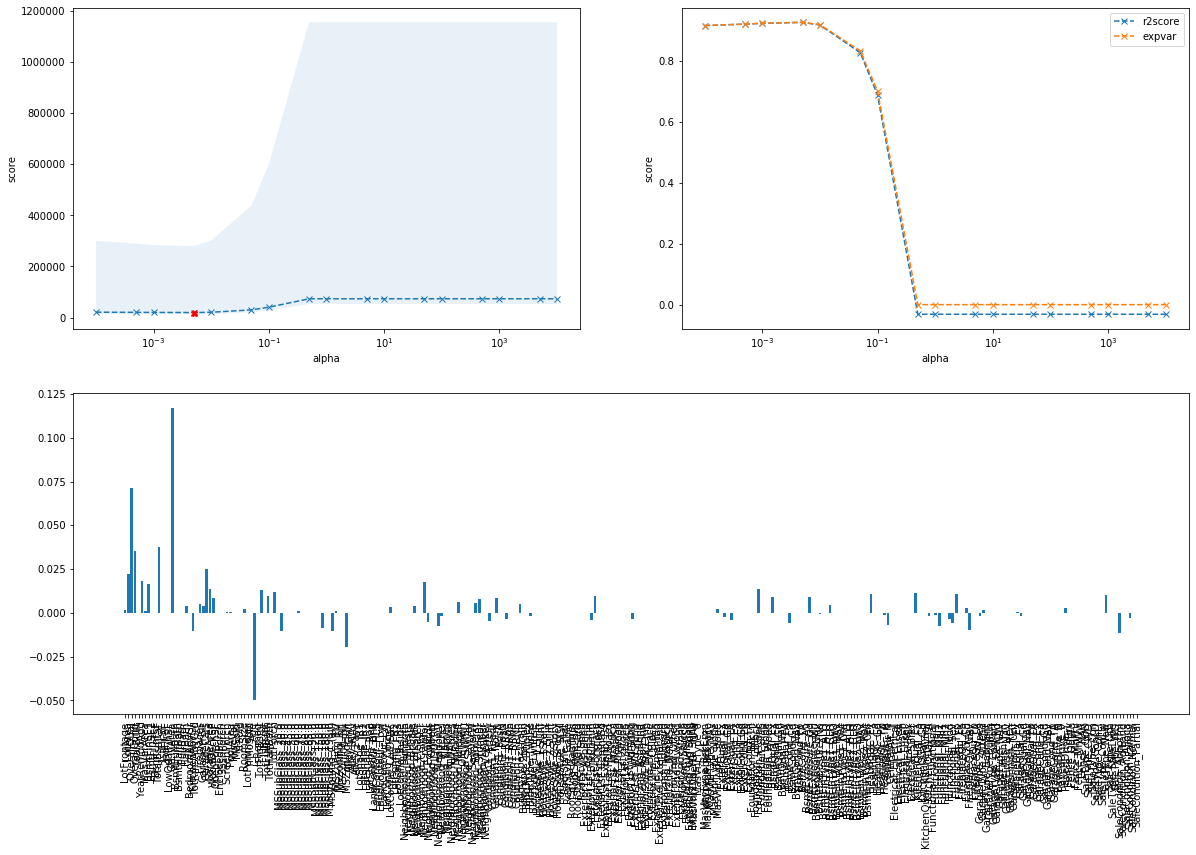

In [7]:
##------Linear Regression------##
# lr = LinearRegression(fit_intercept=False,copy_X=True,n_jobs=-1)
# rmse,r2 = test_model(lr,tr)
# print("Linear Regression:\nRMSE:{:.3f}\nScore:{:.3f}".format(rmse,r2))


##-----Lasso Regression-------##
lasso = Lasso()
hyperparameters = {'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000],
                   'random_state' : [1],
                   'fit_intercept':[True],
                   'max_iter':[2000]}
print( 'Lasso Regression Analysis')
best_params = parameter_select(lasso,hyperparameters,tr,features)

RMSE seems to be quite close to lower bound all the time that means it indicates low error variance. Best value of alpha parameter is highlighted with red color. R2score corresponds to this best alpha value seems to be high (>0.9). That means more than 90 percent of variability can be explained by best Lasso model. Explained variance score is quite close to R2 score it implise our model unbiased which is good indication.

#### **Ridge Regression:**

It is L2 regularization method. It adds penalty equivalent to square of the magnitude of coefficients

Min. objective = Least Square Obj + α * (sum of square of coefficients)

if α = 0, it works as a simple linear regression model. If this vale is greater than 0 it minimizes the coefficient and it tends to zero if α is sufficiently high but not equal to zero. Shrinking the coefficients leads to a lower variance and in hence a lower error value. Therefore Ridge regression decreases the complexity of a model and thus avoids overfitting but does not reduce the number of features, it rather just shrinks their effect.


Ridge Regression Analysis
Best RMSE Score: 20267.464822416863
Best Params {'alpha': 100, 'fit_intercept': True, 'max_iter': 2000, 'random_state': 1}



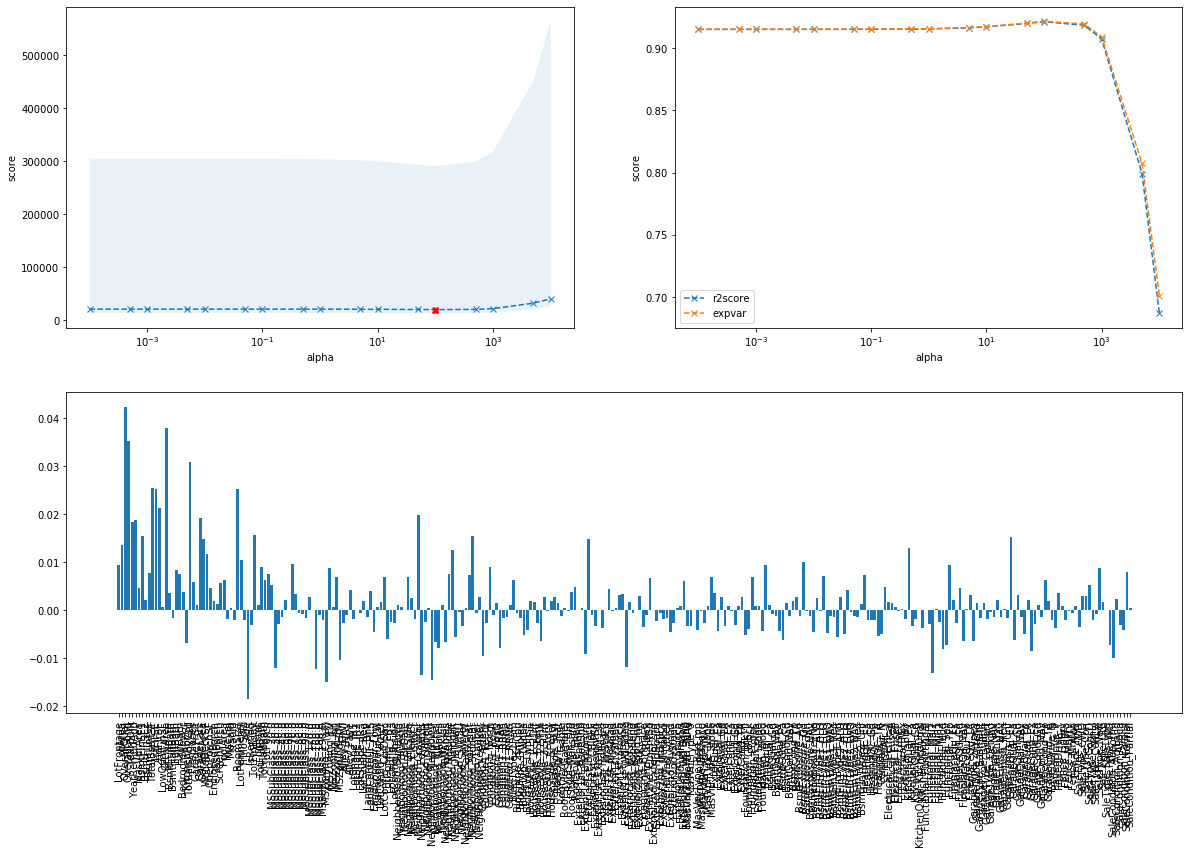

In [8]:
##-----Ridge Regression-------##
ridge = Ridge()
hyperparameters = {'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000],
                   'random_state' : [1],
                   'fit_intercept':[True],
                   'max_iter':[2000]}
print('Ridge Regression Analysis')
best_params = parameter_select(ridge,hyperparameters,tr,features)


Similar behavior as previous has been observed. But the RMSE for best model is slightly higher than previous best model.

#### **Elastic Net :**

Elastic Net which incorporates penalties from both L1 and L2 regularization. This will effectively shrink some coefficients and set some coeff to zero.

Min. Objective = Least Square Obj + a \* L1-penalty + b \* L2-penalty

alpha = a + b and l1_ratio = a / (a + b)              ----- as per sklearn tutorial



Elastic Net regression analysis
Best RMSE Score: 19349.004146817853
Best Params {'alpha': 0.005, 'fit_intercept': True, 'l1_ratio': 0.7, 'max_iter': 2000}



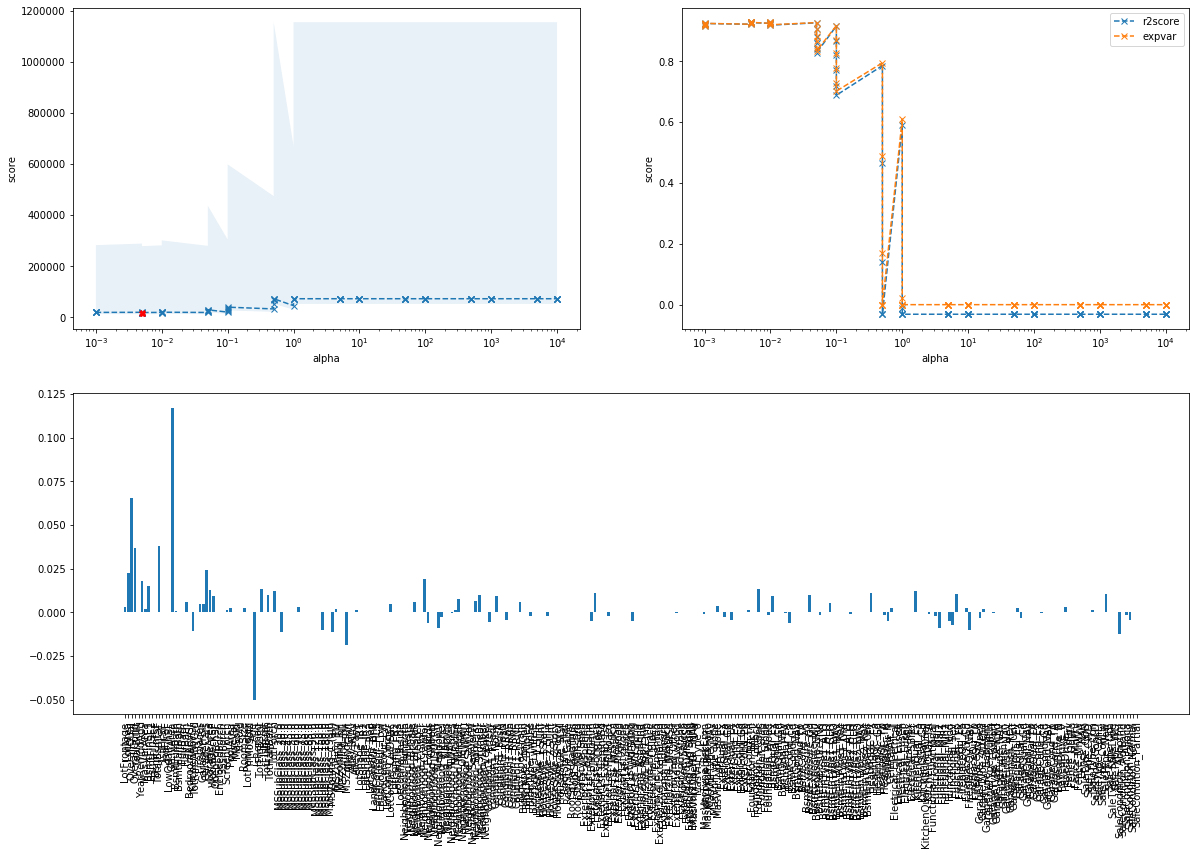

In [9]:

##---ElasticNet Regression----##
eln = ElasticNet()
hyperparameters = {'alpha': [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000],
                   'l1_ratio':[0.1,0.3,0.5,0.7,0.9,1],
                   'fit_intercept':[True],
                   'max_iter':[2000]}

print('Elastic Net regression analysis')
best_params = parameter_select(eln,hyperparameters,tr,features)


Metric plots are not smooth unlike previous two cases. Some abrupt behavior has been observed its because we are varying two parameters at a time i.e alpha and l1-ratio. But for best paramter value, same behaviour as previous has been observed for all metrics.

Elastic Net seems to be out performed among all other linear models w.r.t RMSE score.Therefore Elastic Net model has been chosen as our final model. At further stage, model complexity will be reduced furher by applying recursive feature elimination technique.

## Feature Selection
RFECV i.e. Recursive feture elimination with cross validation has been applied in this feature selection stage. This method recursively eliminates the (less important) feature based on their ranking and train a model with remaining feature/features.It uses the model score(defined by scoring parameter) to identify which features or combination of features contribute the most to predicting the target.

In [10]:
selector = RFECV(Ridge(),step = 1, cv=5,scoring = 'neg_mean_squared_error',n_jobs = -1).fit(tr,train['LogPrice'])
selected_features = trs.columns[selector.support_]

selected_features

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'RoomSize',
       'Age', 'TotFinBsmt', 'TotPorch', 'MSSubClass_30.0', 'MSSubClass_160.0',
       'MSZoning_C (all)', 'MSZoning_RM', 'Neighborhood_BrkSide',
       'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm',
       'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_Wd Sdng',
       'Exterior2nd_CmentBd', 'Exterior2nd_Wd Sdng', 'Foundation_PConc',
       'BsmtExposure_Gd', 'HeatingQC_Ex', 'KitchenQual_Ex', 'Functional_Sev',
       'Functional_Typ', 'FireplaceQu_NAv', 'SaleType_New',
       'SaleCondition_Normal'],
      dtype='object')

Let's train model with selected feature and search for optimum hyper parameter through grid search.

## Hyperparameter selection for selected model with selected features

Best RMSE Score: 18510.091332516447
Best Params {'alpha': 0.001, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 2000, 'random_state': 1, 'tol': 0.0001}



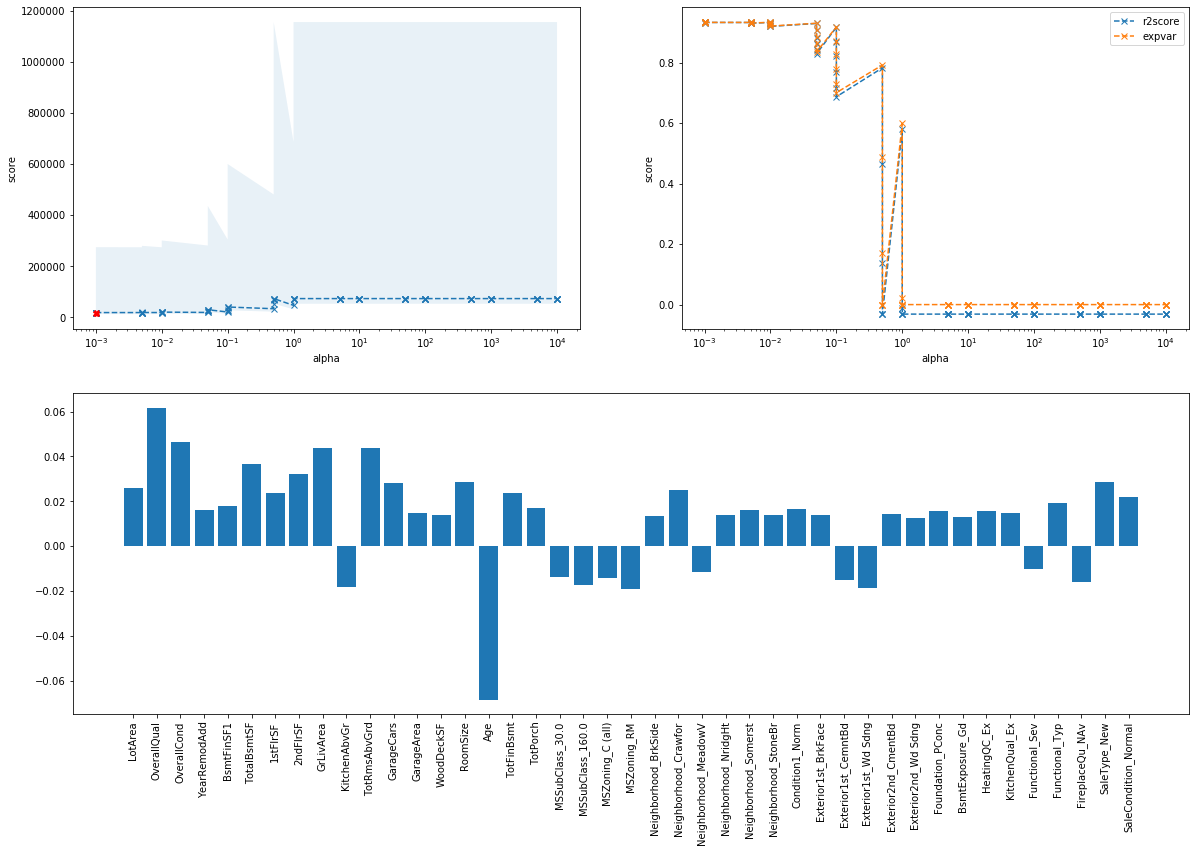

In [11]:
ridge = ElasticNet()
hyperparameters = {'alpha':[0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000],
                   'l1_ratio':[0.1,0.3,0.5,0.7,0.9,1],
                   'random_state' : [1],
                   'fit_intercept':[True],
                   'max_iter':[2000],
                   'tol': [1e-4]}
sc = StandardScaler()
finaltrain =sc.fit_transform(trs[selected_features])
best_params = parameter_select(ridge,hyperparameters,finaltrain,selected_features)


## Evaluate model on test data
Train final model with selected feature and optimum hyperparameter setting and evaluate on test data.

In [12]:

model = ElasticNet(**best_params).fit(finaltrain,train['LogPrice'])

final_test = sc.transform(tes[selected_features])
pred = model.predict(final_test)
pred = np.exp(pred)-1
submission = pd.DataFrame({'Id':test['Id'].astype(int),'SalePrice':pred})
submission.to_csv('submission.csv',index=False)

We have obtained 13809 RMSE on test data which lies in top 3% ranking which indicates that linear model with regularization has ability produce satifactory and competitive performance for given regression problem.